In [1]:
## standart libraries

import os,sys
import numpy as np

import timeit

# xarray
import xarray as xr
import pandas as pd
import datetime
# plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature

# custom tools for plotting
import lib_SLXtools_IMHOTEP_2021 as slx

# for jupyter notebook display
%matplotlib inline

import pkg_resources


In [2]:
prefix = "eORCA025.L75-IMHOTEP"
nexp = "S"
nexpAI = "AI"
nexpREF = "GAI"

varna = 'vfxice' 

# years to read data from:
y1=1980
y2=2018


fo="1y" # output frequency, could be "1y" or "1m"

#  input directory on store
diridatref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"
diridatAI="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpAI+"-S/"
diridat="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexp+"-S/"

# input directory on work
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"

#  input directory on MY work
dirww ="/gpfswork/rech/cli/uor98hu/myncfiles/"


# read grid files
# input directory on work
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"

# read grid files
mesh = xr.open_dataset(diri+'mesh_hgr.nc')
tmask = mesh.tmask[0,0,:,:] # grille lat/lon
nav_lon = mesh.nav_lon
nav_lat = mesh.nav_lat
e1t = mesh.e1t
e2t = mesh.e2t
mbathy = xr.open_dataset(diri+'eORCA025.L75_domain_cfg_closed_seas_greenland.nc')['bathy_meter'].isel(t=0) # grille lat/lon

In [3]:
%%time
# creating a dataset with the variable vfxice for the years over period y1-y2

# new numpy matrix
# setting the dimensions: x, y t
t_dim = y2-y1+1
x_dim = 1442
y_dim = 1207
#creating the 3 matrix to obtain
sivolu_matrix = np.ones((t_dim, y_dim, x_dim))
sivolu_matrixREF = np.ones((t_dim, y_dim, x_dim))
sivolu_matrixAI = np.ones((t_dim, y_dim, x_dim))

yr_counter =0
for yr in np.arange(y1,y2+1):
    filepath = diridat+fo+"/"+str(yr)+"/"+prefix+"."+nexp+"_y"+str(yr)+".1y_icemod.nc"
    filepathREF = diridatref+fo+"/"+str(yr)+"/"+prefix+"."+nexpREF+"_y"+str(yr)+".1y_icemod.nc"
    filepathAI = diridatAI+fo+"/"+str(yr)+"/"+prefix+"."+nexpAI+"_y"+str(yr)+".1y_icemod.nc"
    
    #opening the file
    S1y = xr.open_dataset(filepath,decode_times=False)[varna]
    REF1y = xr.open_dataset(filepathREF,decode_times=False)[varna]
    AI1y = xr.open_dataset(filepathAI,decode_times=False)[varna]
    
    # Saving the yearly data in the new matrix
    sivolu_matrix[yr_counter,:,:]   = S1y.isel(time_counter=0).values
    sivolu_matrixREF[yr_counter,:,:]= REF1y.isel(time_counter=0).values
    sivolu_matrixAI[yr_counter,:,:] = AI1y.isel(time_counter=0).values
    #print(yr)
    yr_counter+=1


CPU times: user 6.29 s, sys: 1.45 s, total: 7.73 s
Wall time: 25.1 s


In [4]:
#creating the coordinates for the datarray
time = pd.date_range(start=str(y1), end=str(y2+1), freq='Y')
lats = nav_lat.values
longs = nav_lon.values

dasivolu = xr.DataArray(data=sivolu_matrix, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="ice-ocean fw flux from ice melt/growth",units="kg/m2/s"))

dasivoluREF = xr.DataArray(data=sivolu_matrixREF, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="ice-ocean fw flux from ice melt/growth",units="kg/m2/s"))

dasivoluAI = xr.DataArray(data=sivolu_matrixAI, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="ice-ocean fw flux from ice melt/growth",units="kg/m2/s"))

### Converting to freshwater content

In [5]:
cellArea = e1t.isel(time_counter=0)*e2t.isel(time_counter=0).compute()
#durée en sec de chaque année
timebis = pd.date_range(start=str(y1-1), end=str(y2), freq='Y')
timesec = xr.DataArray(data=(time - timebis).days*24*60*60, dims=["time_counter"],coords=dict(time_counter=time))

In [6]:
%%time
fw_REF = (dasivoluREF/1000*cellArea*timesec).compute()
fw_AI = (dasivoluAI/1000*cellArea*timesec).compute()

CPU times: user 740 ms, sys: 639 ms, total: 1.38 s
Wall time: 1.39 s


# in boxBG

In [7]:
fw_REF = fw_REF.where((nav_lon>-152.5) & (nav_lon<-140.5) &(nav_lat>72.3) & (nav_lat<77.3), drop=True)
fw_AI = fw_AI.where((nav_lon>-152.5) & (nav_lon<-140.5) &(nav_lat>72.3) & (nav_lat<77.3), drop=True)

In [8]:
fw_REFtot = fw_REF.sum(('x','y'))
fw_AItot = fw_AI.sum(('x','y'))
fw_GAI_AItot = fw_REFtot -fw_AItot

In [73]:
from scipy import stats 
#compute linear trend
diff_ts = (fw_GAI_AItot/1e12).sel(time_counter=slice('1998','2011'))
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(14),diff_ts)
r_value**2

0.03168315576199085

In [74]:
courbe = [ slope*i+intercept for i in np.arange(14)]

In [ ]:
# pourcentage  et stats

In [88]:
REFmean = (fw_REFtot/1e12).sel(time_counter=slice('1998','2011')).mean()

In [86]:
tsdiff =(fw_GAI_AItot/1e12).sel(time_counter=slice('1998','2011'))
amplitude = tsdiff.max() - tsdiff.min()

In [90]:
amplitude

<xarray.DataArray ()>
array(0.03587937)

In [89]:
amplitude/REFmean

<xarray.DataArray ()>
array(0.79033387)

### plot

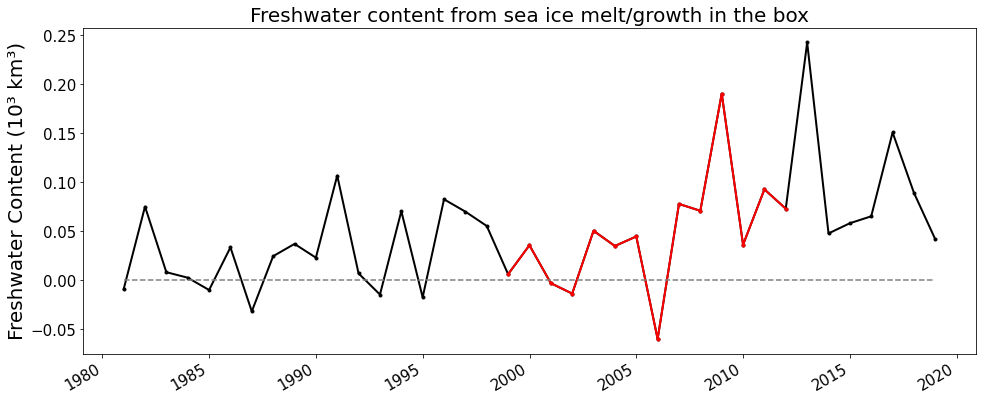

from annual data


In [76]:
# time series FWC run GAI in box BG
plt.figure(figsize=([16,6]),facecolor='white')
(fw_REFtot/1e12).plot(color='k',linewidth=2,marker='.')
(fw_REFtot/1e12).sel(time_counter=slice('1998','2011')).plot(color='r',linewidth=2,marker='.')
plt.plot(fw_REFtot.time_counter,np.zeros(39),linestyle='--',color='grey')

plt.title('Freshwater content from sea ice melt/growth in the box', size=20)
plt.xlabel(None)
plt.ylabel('Freshwater Content (10³ km³)',fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)

plt.show()
print("from annual data")

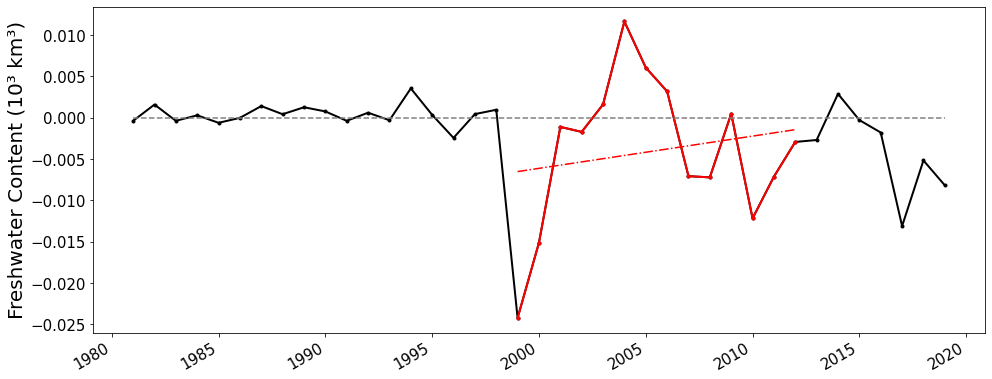

from annual data


In [75]:
# GAI - AI
plt.figure(figsize=([16,6]),facecolor='white')
(fw_GAI_AItot/1e12).plot(color='k',linewidth=2,marker='.')
(fw_GAI_AItot/1e12).sel(time_counter=slice('1998','2011')).plot(color='r',linewidth=2,marker='.')
plt.plot(diff_ts.time_counter,courbe,color='r',linestyle='-.')
plt.plot(fw_GAI_AItot.time_counter,np.zeros(39),linestyle='--',color='grey')

#plt.legend('GAI')
plt.xlabel(None)
plt.ylabel('Freshwater Content (10³ km³)',fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)

plt.show()
print("from annual data")